In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
b = BLEPipeline()

In [4]:
# b.extract_packet_features(create_master=True)

In [5]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


In [6]:
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length", "Time", 
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

## Resample

### Downsampling

In [7]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'DeviceName', 'Set', 
                  'AccessAddr', 'AdvertAddr','PDUTypeNum'}
onehotEncoded_vars = {'ADV_DIRECT_IND', 'ADV_IND', 
                      'ADV_NONCONN_IND', 'ADV_SCAN_IND', 
                      'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP'}
response_vars = {"DeviceType","door","lock","temp"}
ble_devicetypes = ["door","lock","temp"]

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | onehotEncoded_vars
X = df_train.drop(col_drop, axis=1)

### Create trial dataframes

In [8]:
df_trials = []

while len(df_trials) != 10:
    df_downsampled = b.downsample(X, y, df[df["Set"]=="test"])

    # Ensure that the trial sample contains all features in feature list
    if set(features_list).issubset(set(df_downsampled.columns)):
        df_trials.append(df_downsampled)

## Run trials

In [9]:
df_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = b.one_vs_all_classify(trial, [x for x in features_list if x in trial.columns], y_list)
    df_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports

In [10]:
b.create_csv_results('ble', df_results)

### AUC

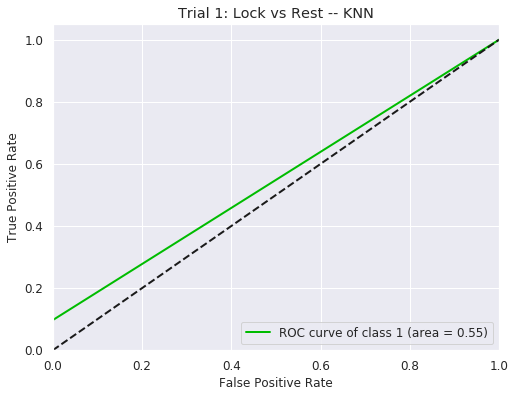

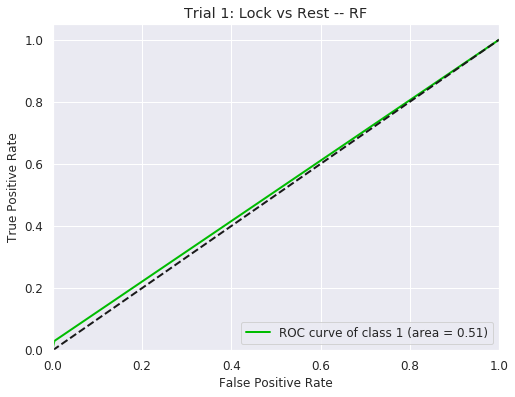

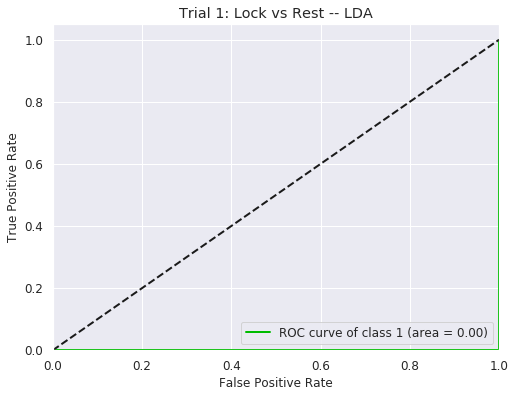

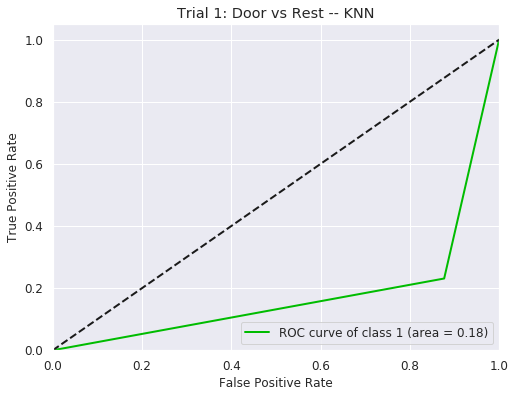

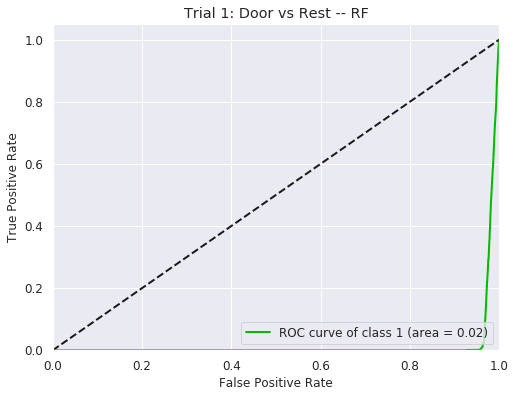

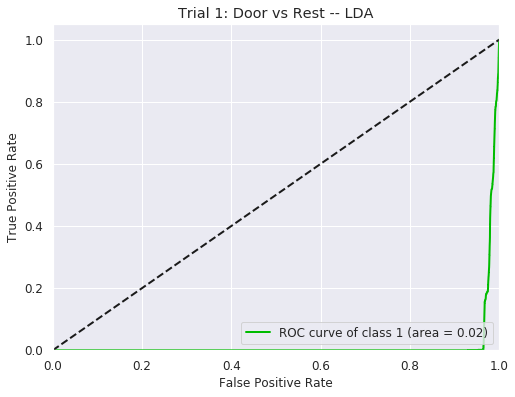

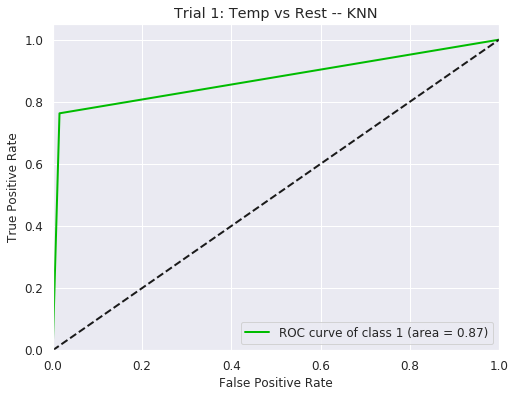

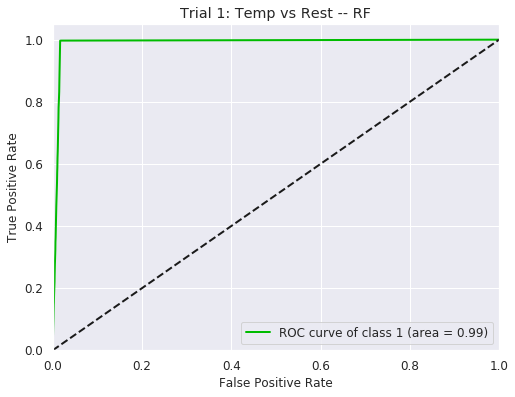

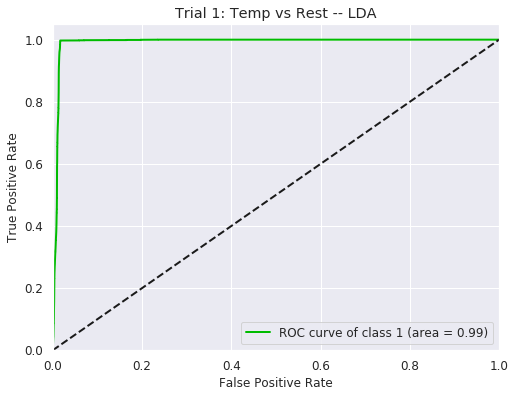

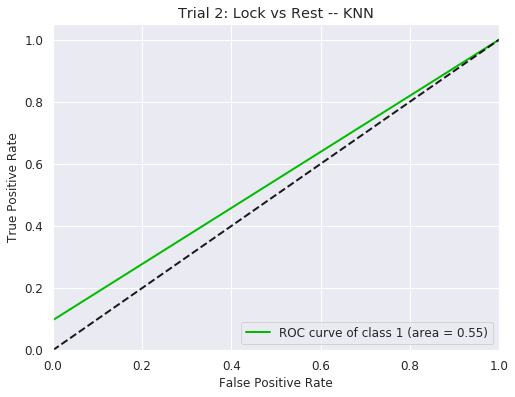

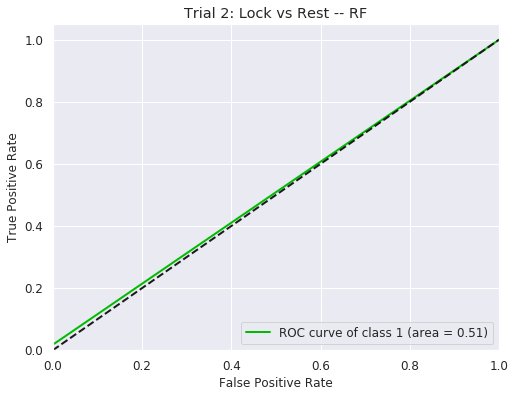

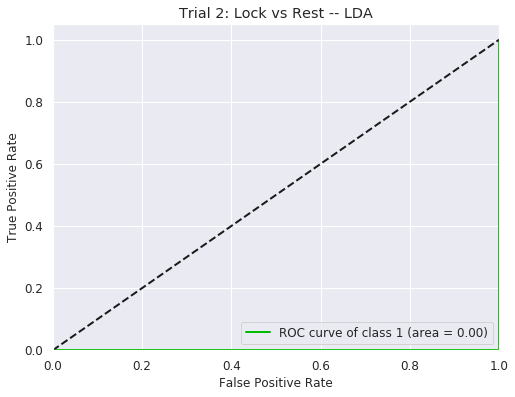

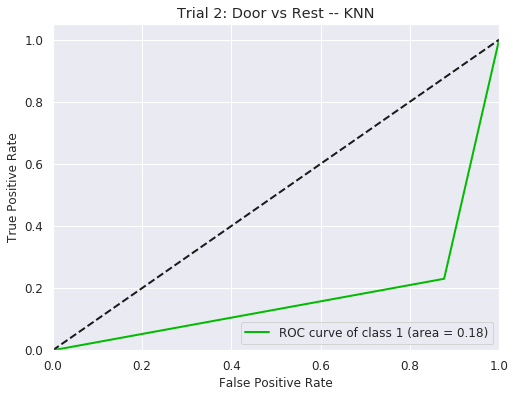

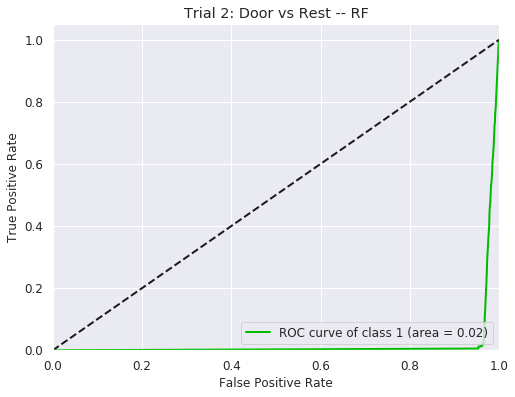

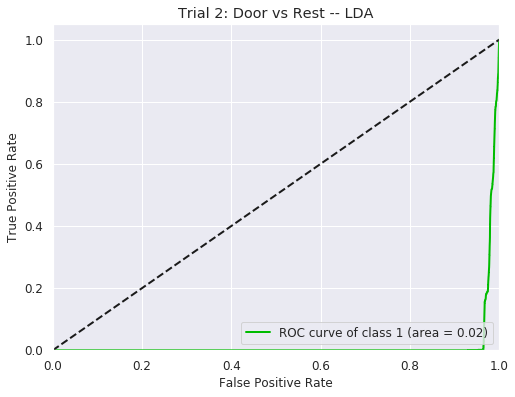

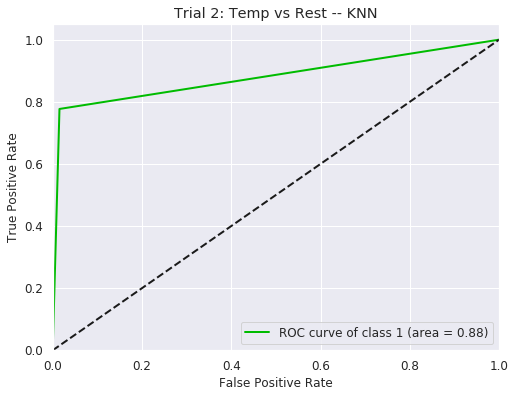

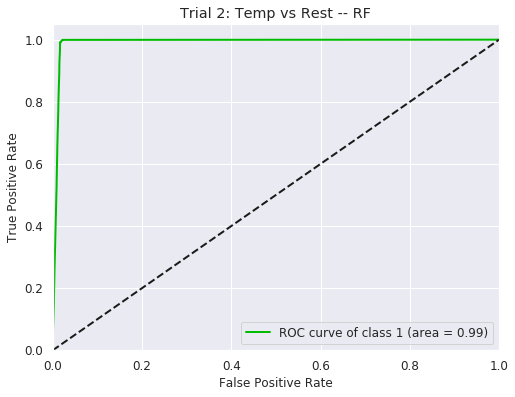

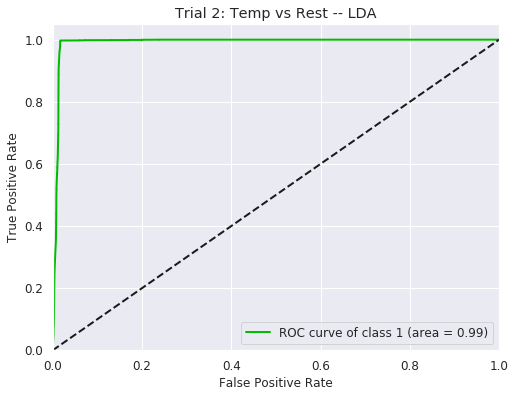

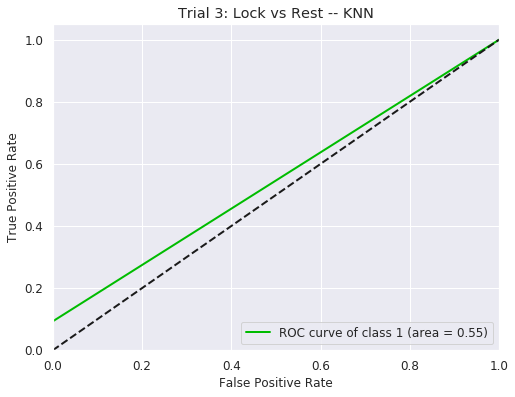

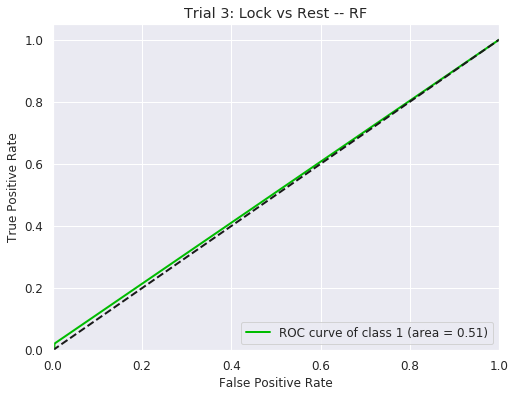

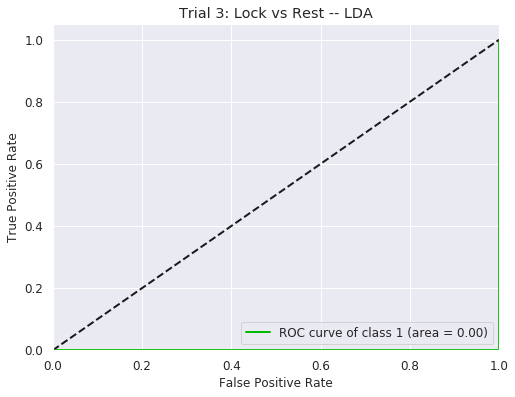

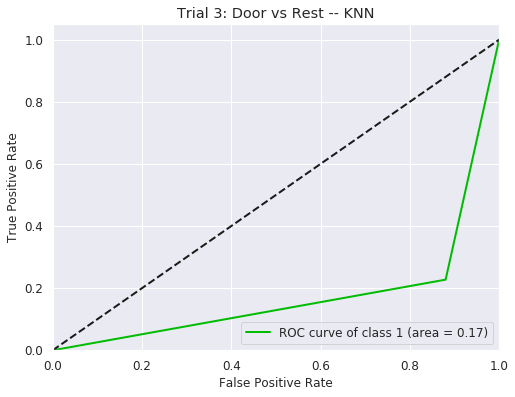

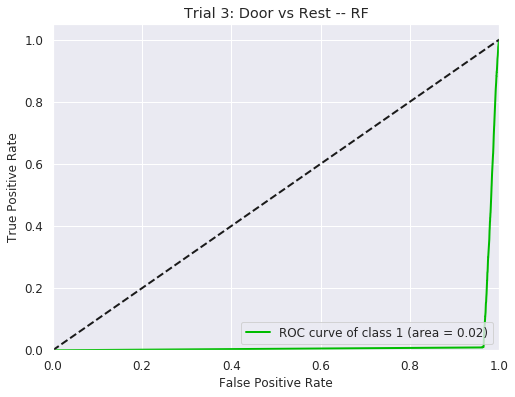

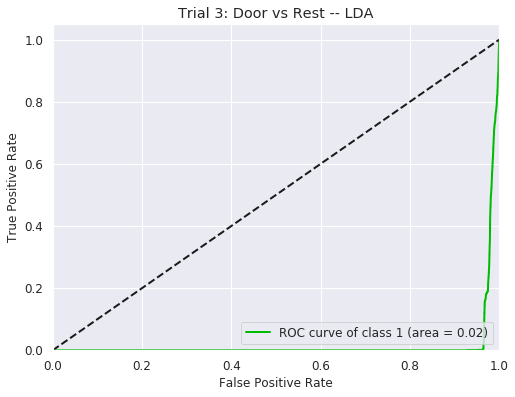

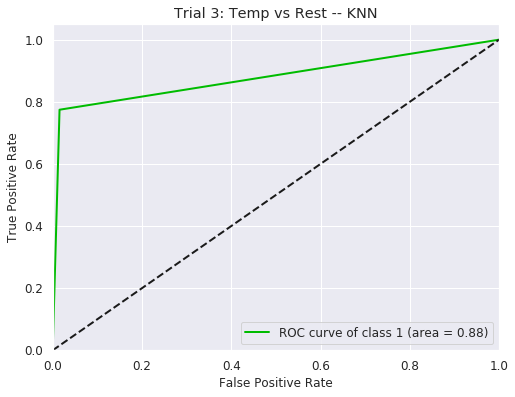

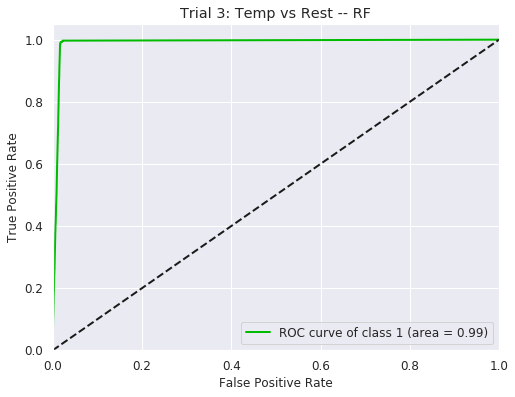

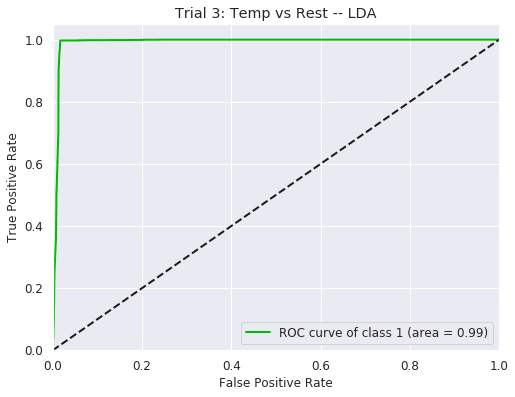

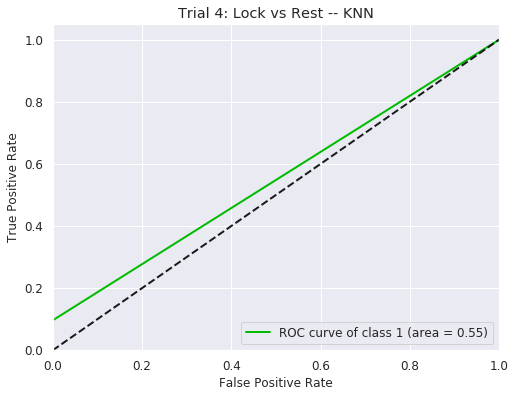

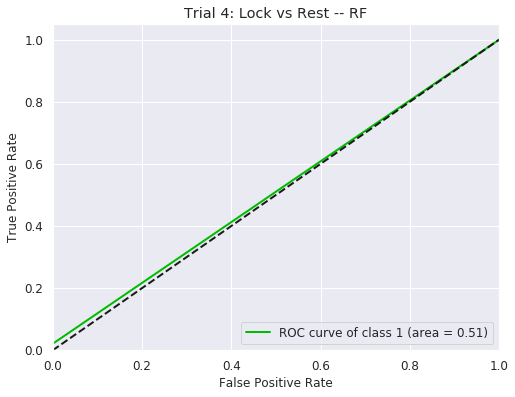

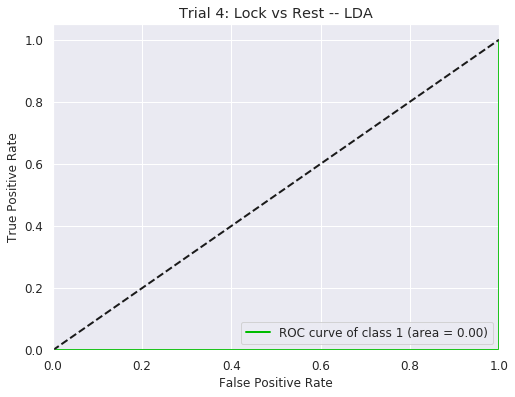

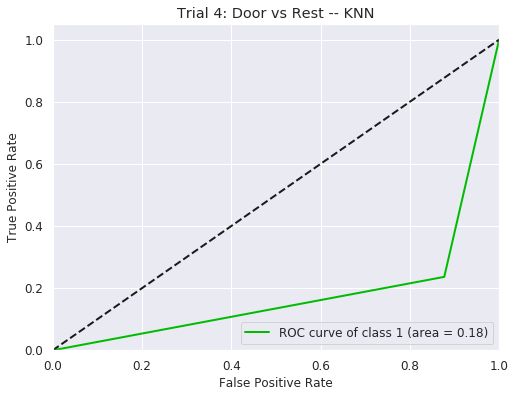

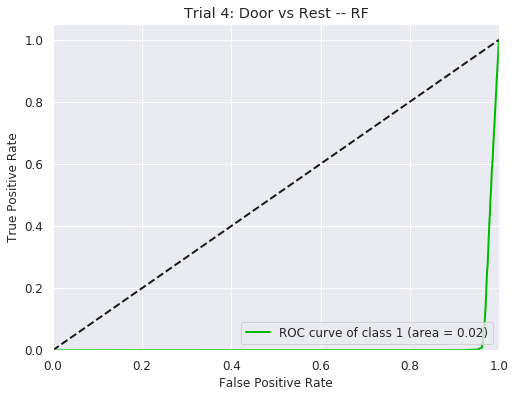

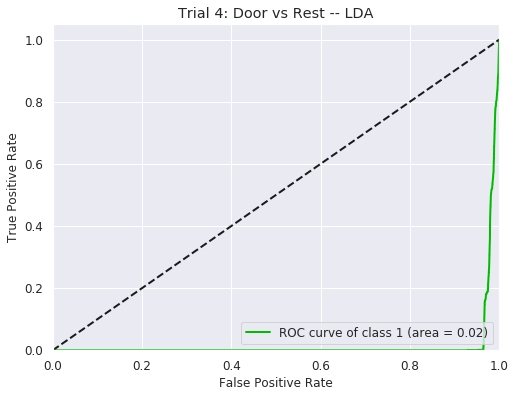

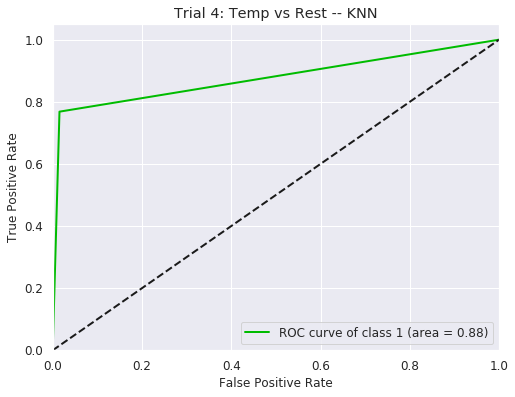

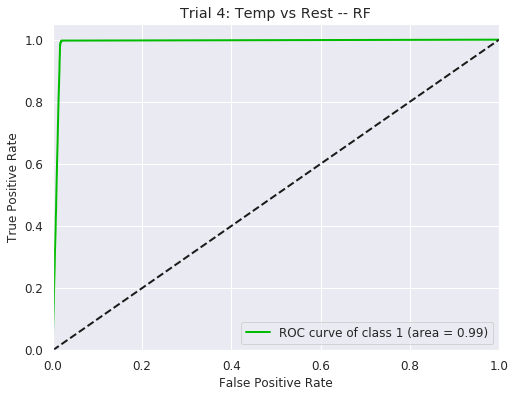

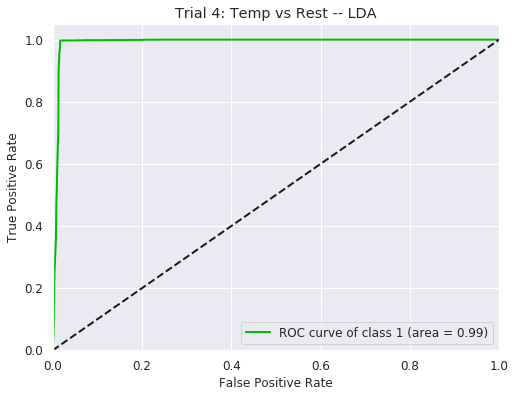

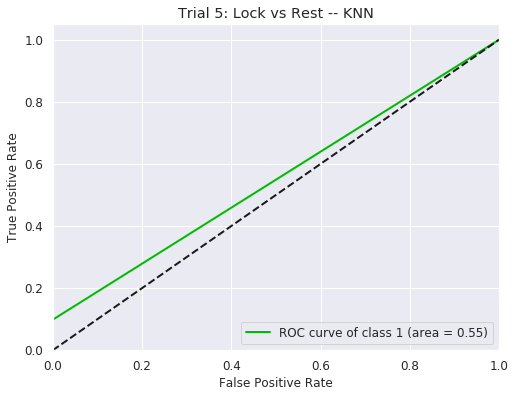

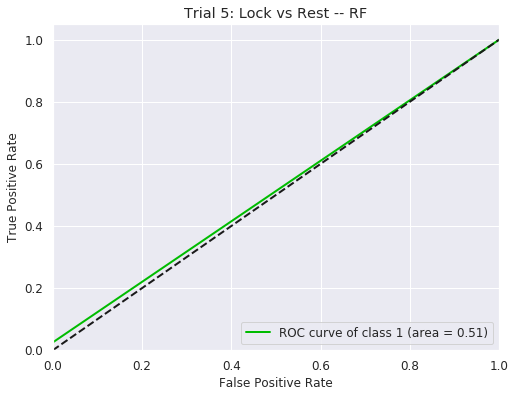

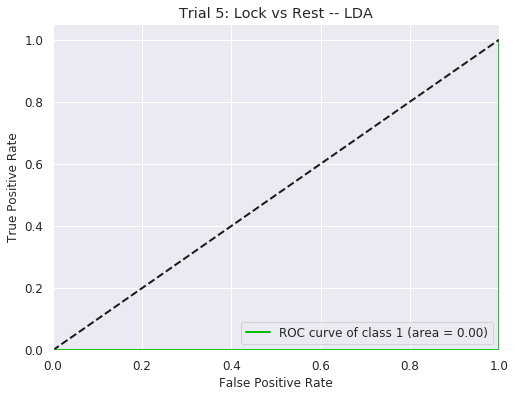

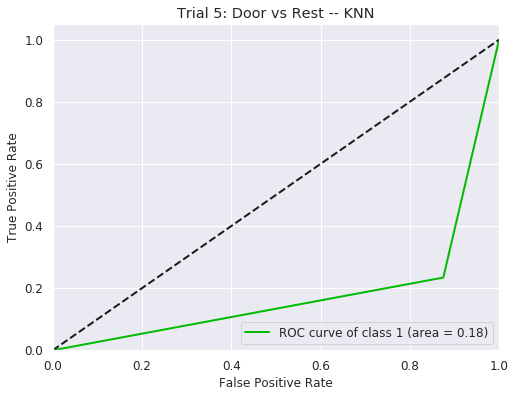

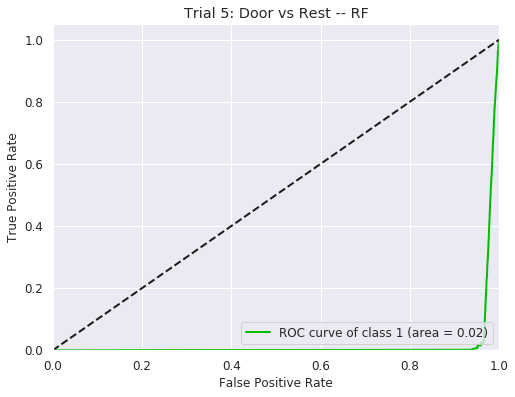

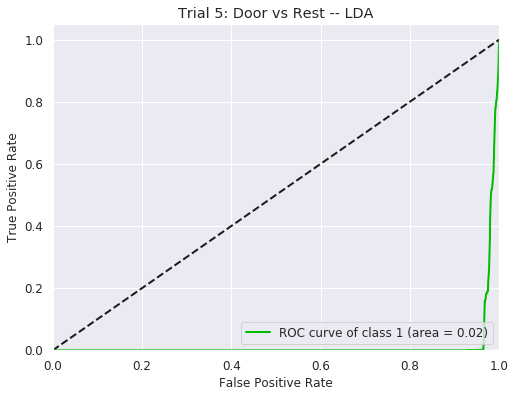

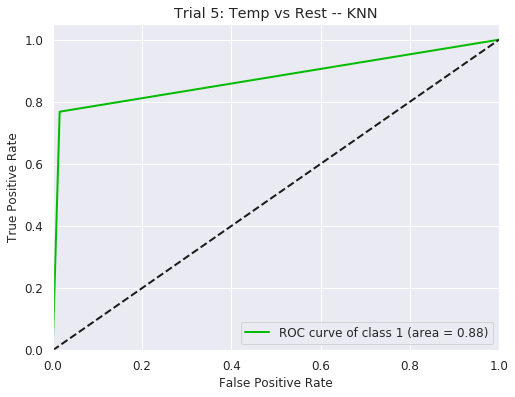

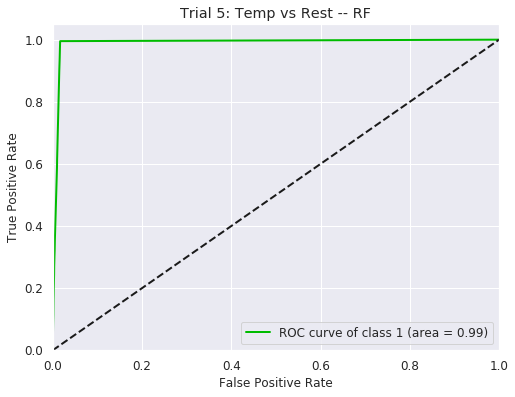

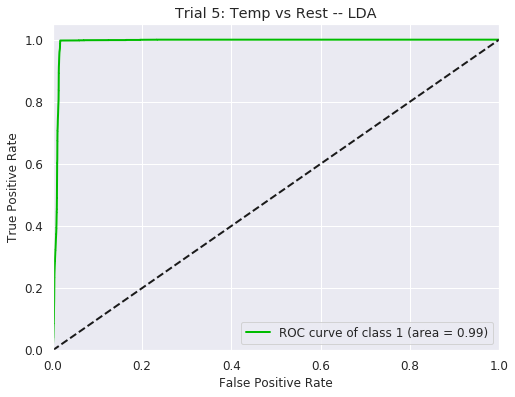

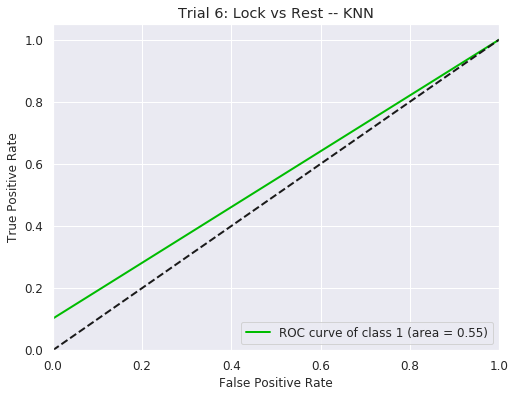

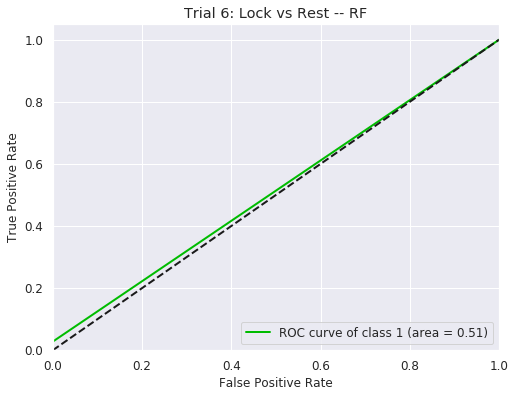

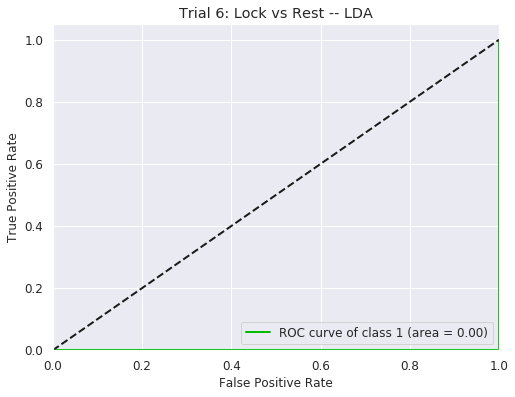

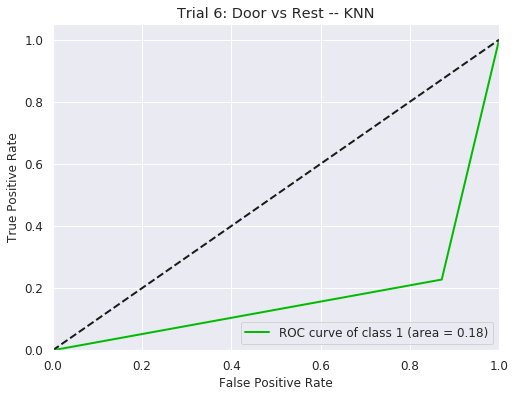

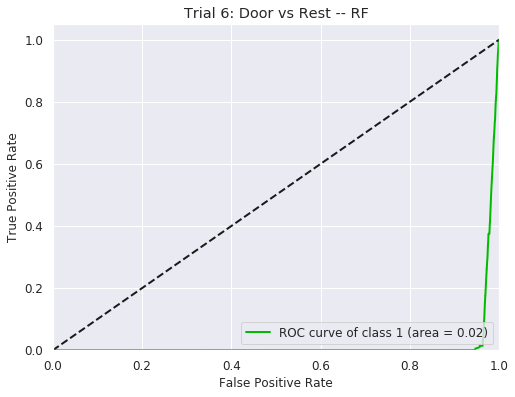

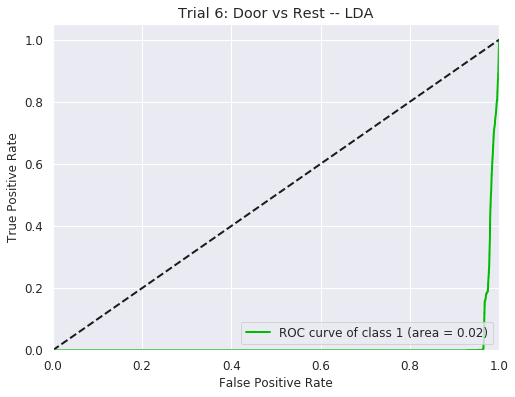

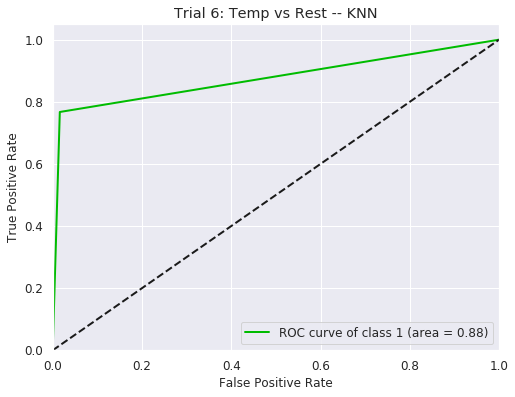

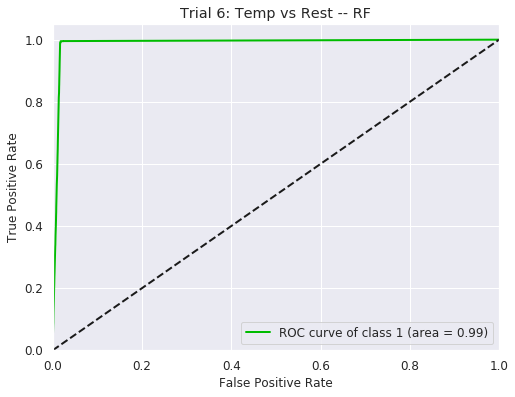

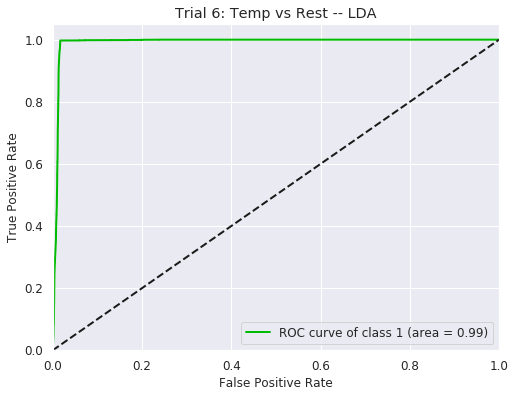

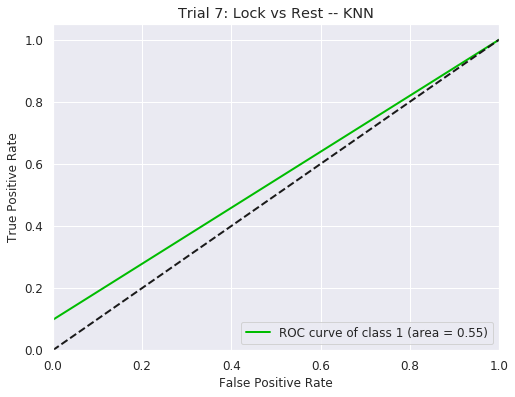

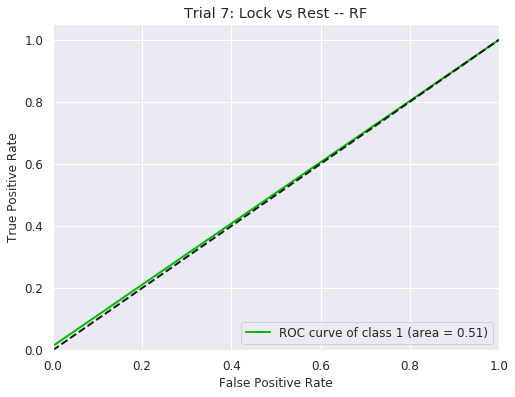

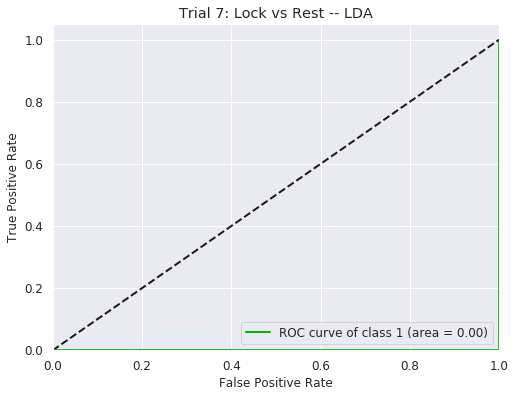

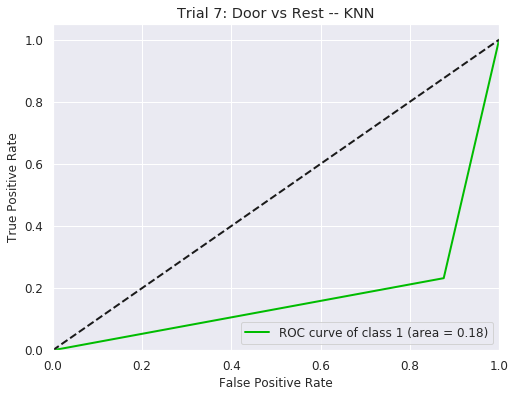

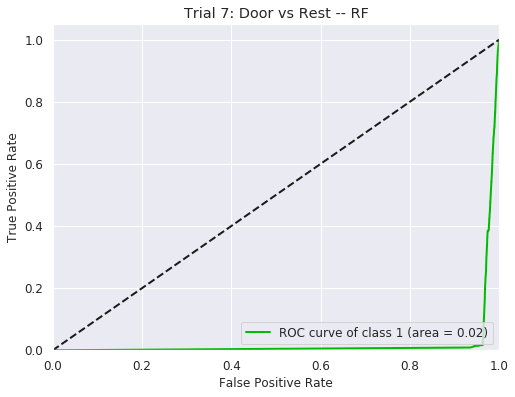

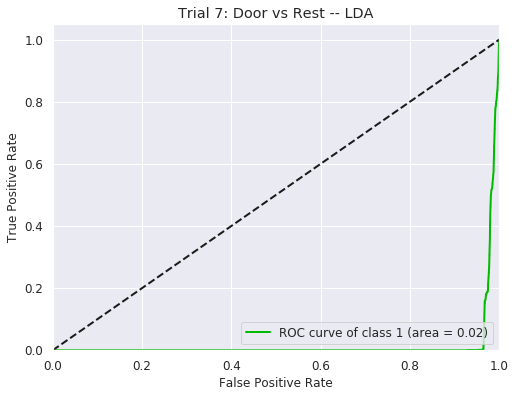

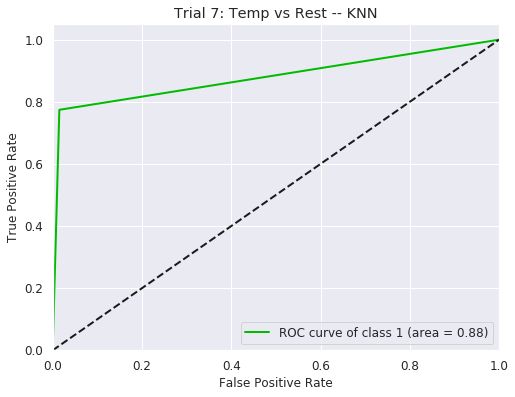

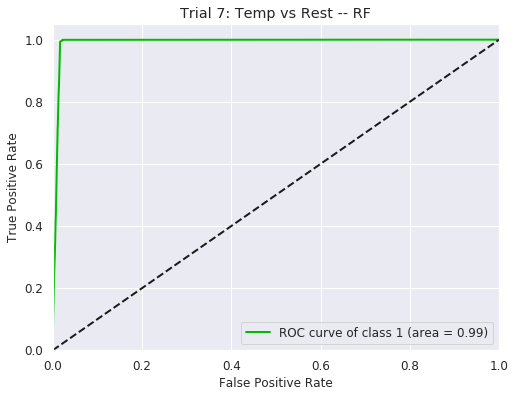

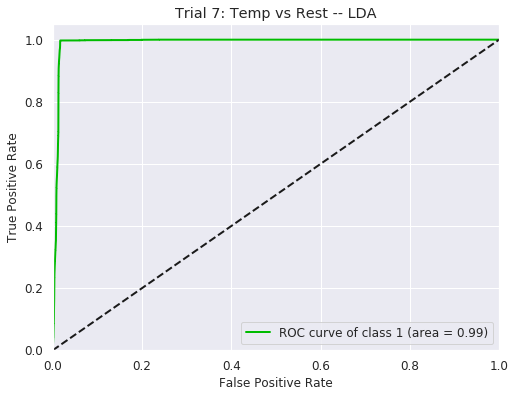

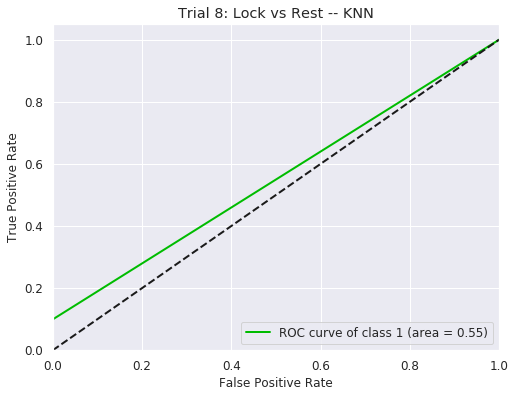

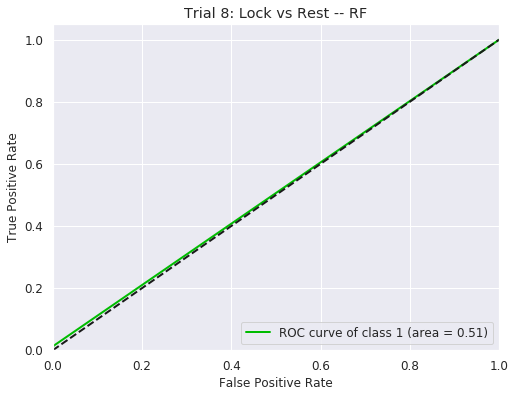

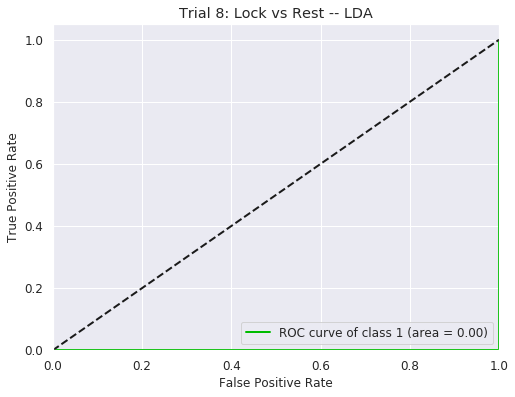

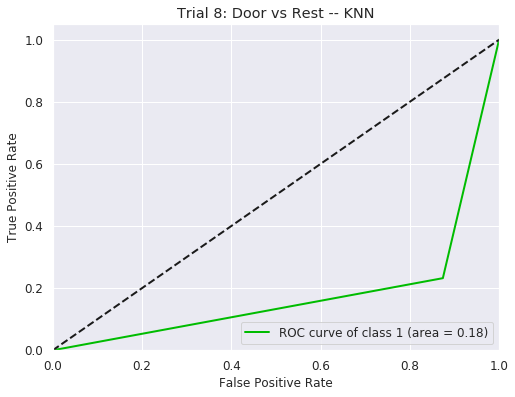

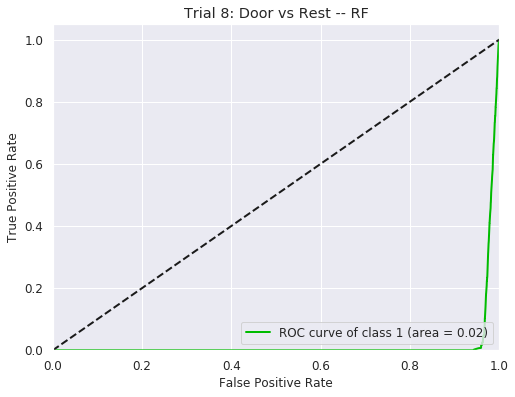

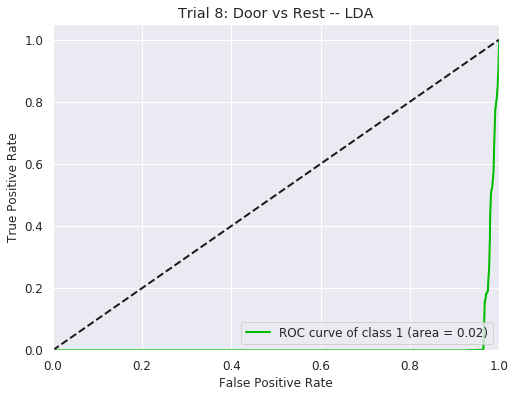

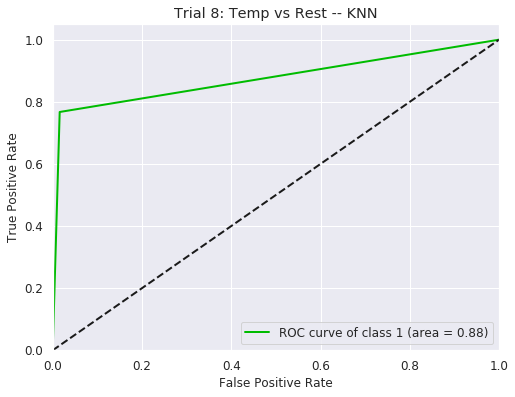

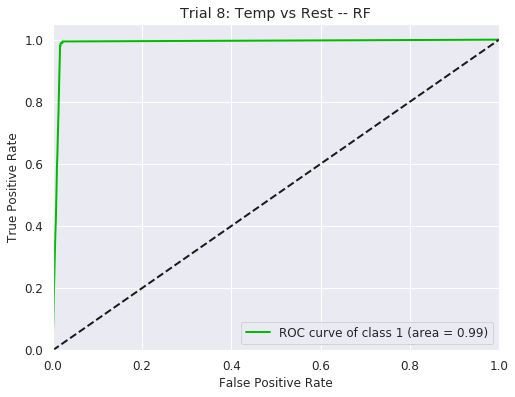

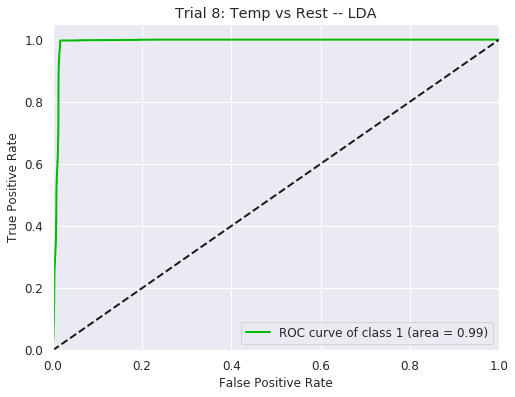

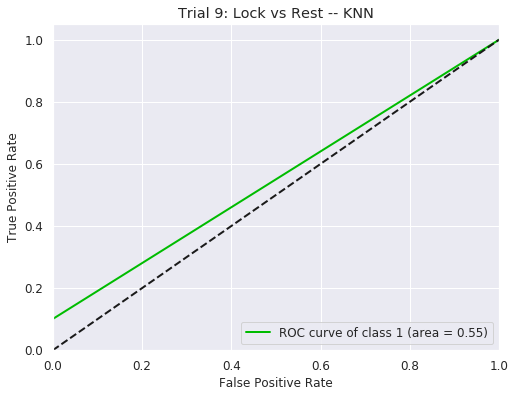

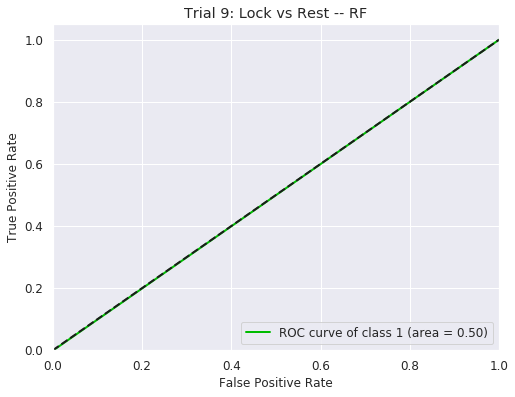

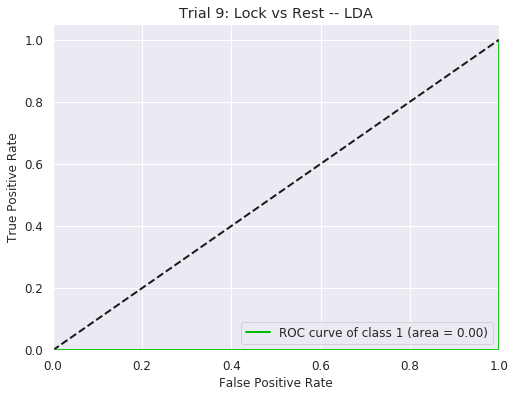

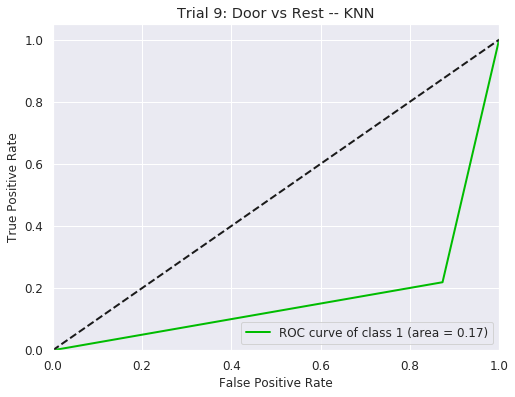

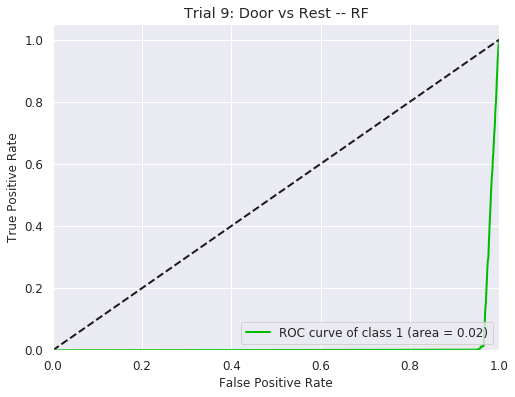

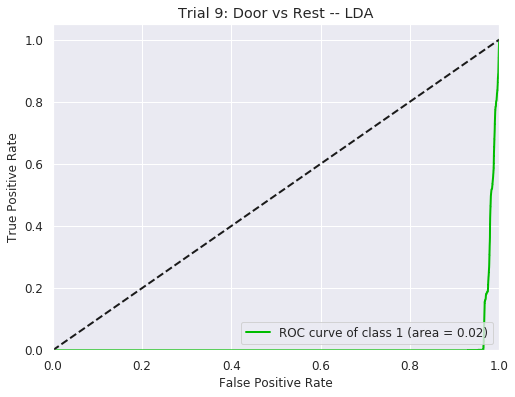

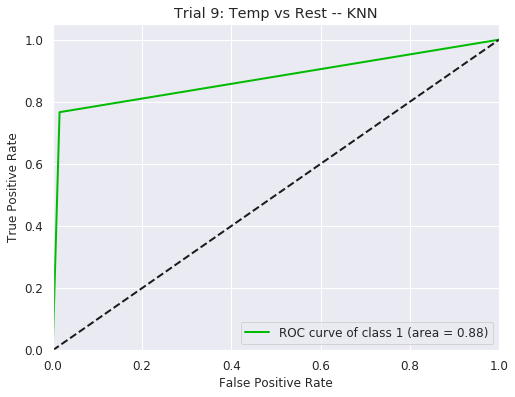

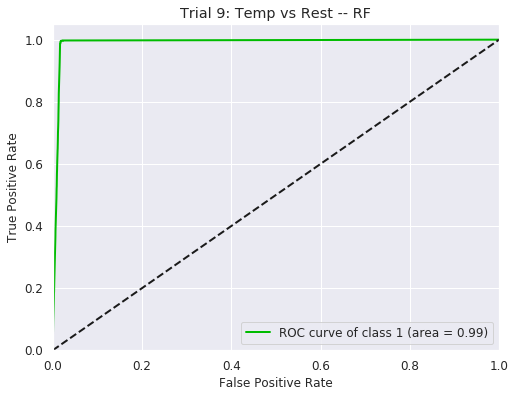

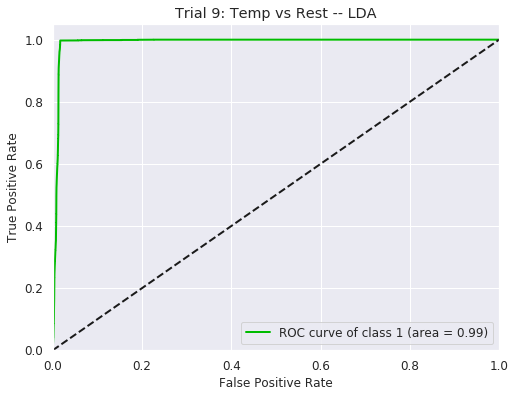

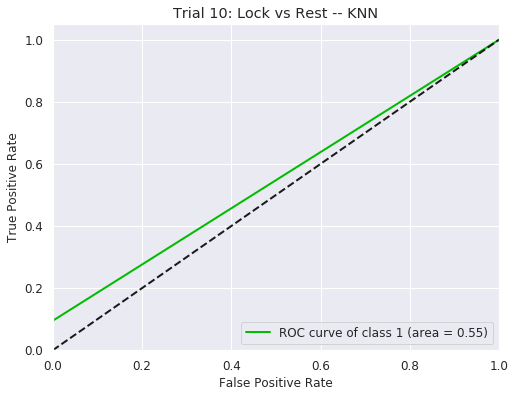

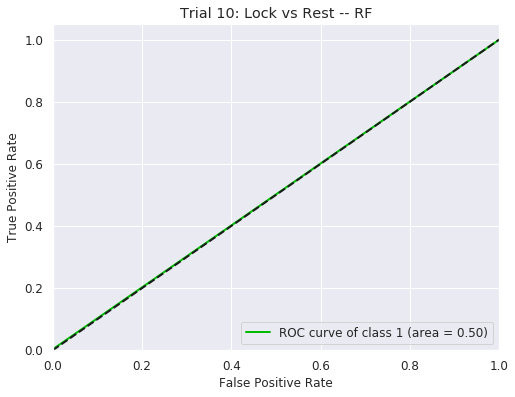

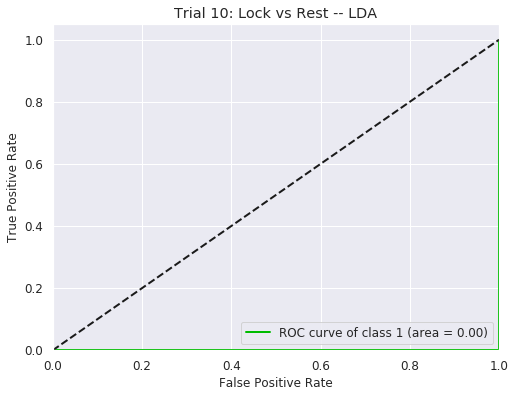

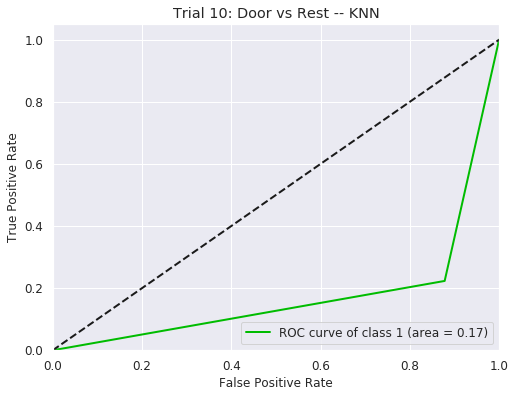

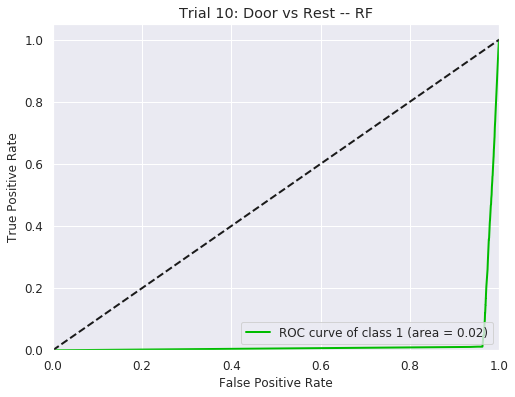

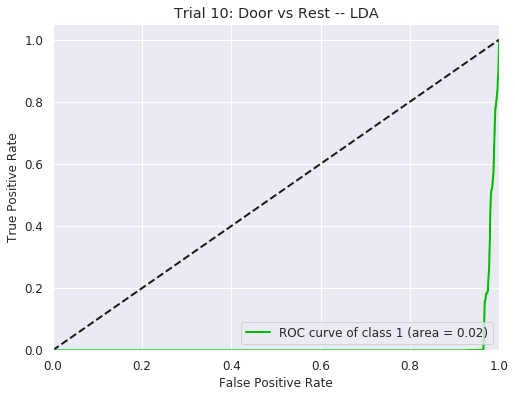

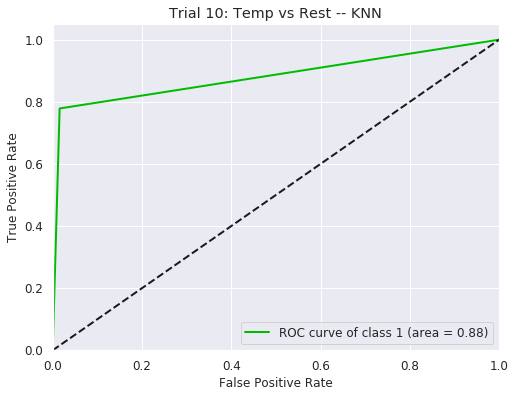

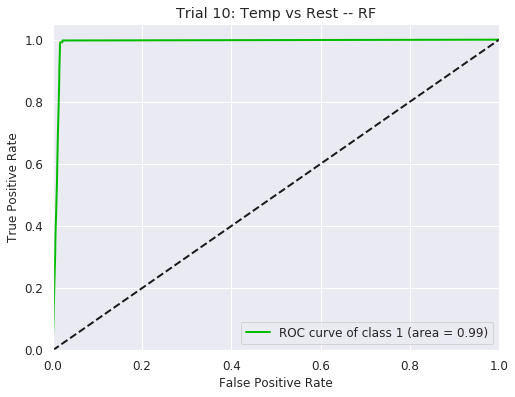

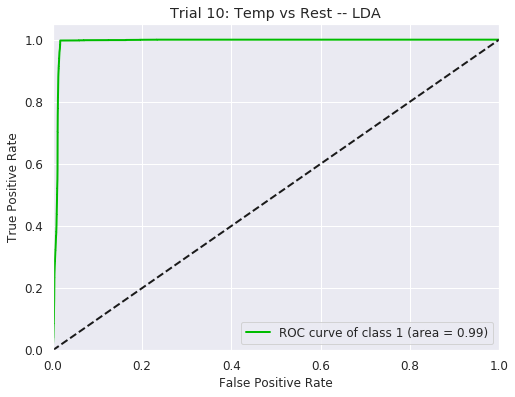

In [11]:
# Plotting ROC curves
sns.set(font_scale=1)

for trial_num, result in enumerate(df_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()
    
    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Plot ROC curve
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));

### Time Performance

In [12]:
for trial_num, result in enumerate(df_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in y_list:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 24.6980741024 seconds
(Door, KNN) : 5.03770899773 seconds
(Door, RF) : 1.32893180847 seconds
(Door, LDA) : 0.677345991135 seconds
(Lock, KNN) : 4.97977995872 seconds
(Lock, RF) : 1.19253706932 seconds
(Lock, LDA) : 0.696048021317 seconds
(Temp, KNN) : 5.12245202065 seconds
(Temp, RF) : 1.15409183502 seconds
(Temp, LDA) : 0.668063163757 seconds

Trial  1
Total time: 24.6555528641 seconds
(Door, KNN) : 5.10146713257 seconds
(Door, RF) : 1.26370692253 seconds
(Door, LDA) : 0.669555902481 seconds
(Lock, KNN) : 5.04424285889 seconds
(Lock, RF) : 1.14308595657 seconds
(Lock, LDA) : 0.678576946259 seconds
(Temp, KNN) : 5.12958502769 seconds
(Temp, RF) : 1.18853783607 seconds
(Temp, LDA) : 0.665615797043 seconds

Trial  2
Total time: 24.7091031075 seconds
(Door, KNN) : 5.05091881752 seconds
(Door, RF) : 1.29483485222 seconds
(Door, LDA) : 0.668975114822 seconds
(Lock, KNN) : 5.06620287895 seconds
(Lock, RF) : 1.17243385315 seconds
(Lock, LDA) : 0.701251983643 seconds
(Temp

### Feature Importance

In [13]:
df_featImp = pd.DataFrame()
for i,f in enumerate(b.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [14]:
import numpy as np, scipy.stats as st
a = df_featImp.iloc[:,0:30].T
lower, upper = st.t.interval(0.90, len(a)-1, loc=np.mean(a), scale=st.sem(a))

In [15]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_Lower'] = lower
df_featImp['CI_Upper'] = upper

In [16]:
display(df_featImp[['Mean', 'StdDev', 'CI_Lower', 'CI_Upper']].sort_values('Mean', ascending=False))

,Mean,StdDev,CI_Lower,CI_Upper
BLE_LL_Length,0.306780,0.156816,0.257302,0.356259
PacketLength,0.260050,0.111549,0.224854,0.295246
SCAN_RSP,0.187139,0.135880,0.144266,0.230012
Assoc_Packets,0.136875,0.090831,0.108216,0.165534
ADV_IND,0.085012,0.060167,0.066028,0.103996
SCAN_REQ,0.017370,0.017191,0.011945,0.022794
Time,0.005713,0.003600,0.004577,0.006849
Channel_12,0.000715,0.001043,0.000386,0.001044
Channel_39,0.000163,0.000264,0.000079,0.000246
Channel_0,0.000079,0.000061,0.000059,0.000098


### Plots

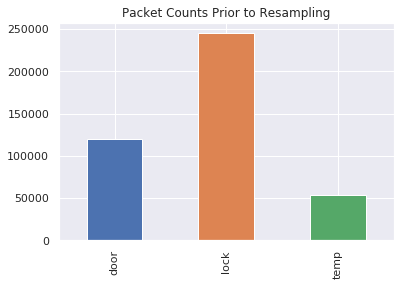

In [17]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

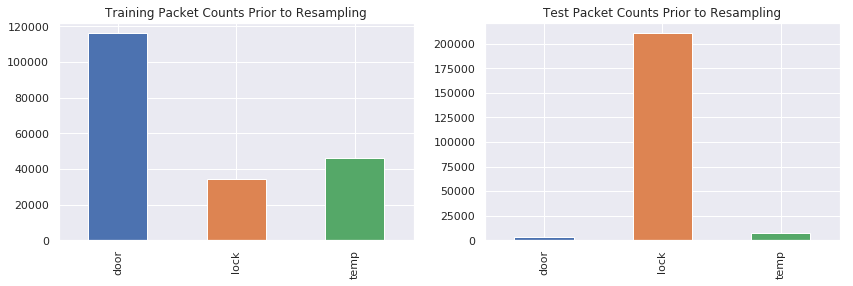

In [18]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


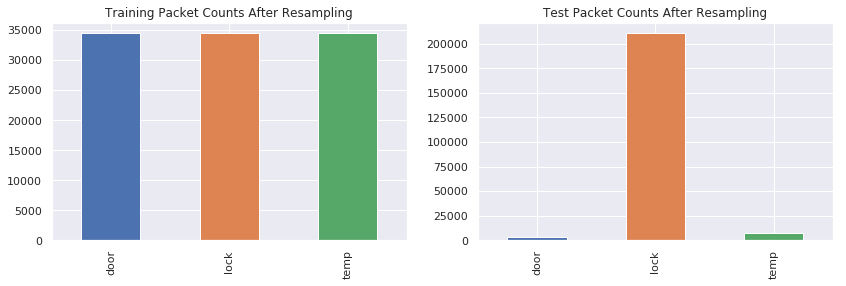

In [19]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[ble_devicetypes].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
